# Introduction to Machine Learning

In [3]:
# PREAMBLE
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import datetime
import scipy

%matplotlib inline
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

### Predicting Peak Electrical Power with Linear Regression

Load the data set in csv format using pandas.

In [4]:
# load all data
df = pd.read_csv('/tempdemandsummer.csv',sep=' ', index_col='Date')
df.index = pd.to_datetime(df.index)
print(df)

             Temp     Load  IsWeekday
Date                                 
2013-06-01  84.92  2.29866      False
2013-06-02  80.06  2.02608      False
2013-06-03  69.08  1.83254       True
2013-06-04  71.96  1.82701       True
2013-06-05  80.06  2.10931       True
...           ...      ...        ...
2013-06-02  78.08  1.71487      False
2013-06-08  75.02  1.83368      False
2013-06-09  75.02  1.84533      False
2013-06-15  77.00  1.91130      False
2016-07-04  75.92  1.91317       True

[357 rows x 3 columns]


### Exploring the data

Before starting on any task, it is often useful to understand the data by visualizing it. In this example it can be done using a scatter plot since we only have two variables (temperature and load).

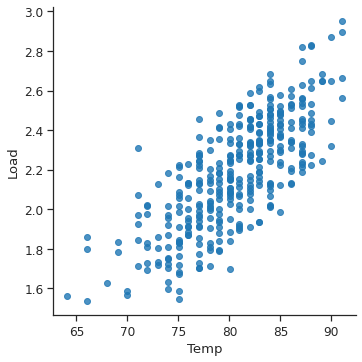

In [5]:
sns.lmplot(x='Temp', y='Load', data=df, fit_reg=False)

### Feature Scaling

Scale the temperature column such that it has zero mean and unit variance.
It is best not to overwrite `df['Temp']`, but to create a new column `df['Temp Normalized']`.
Compare this to Figure 1.4 in the script.

### Bias Term
In order to facilitate the vector notation $w^Tx$ we add a bias term to the vector $x$ i.e. an element with the value $1$.

In [6]:
# add bias term
df['Bias'] = 1
#df['Temp_Normalized'] = ( df['Temp'] - min(df['Temp']) ) / (max(df['Temp']) - min (df['Temp'])) # Min-Max normalisation
df['Temp_Normalized'] = ( df['Temp'] - np.mean(df['Temp']) ) / (np.std(df['Temp']))
print(df)

             Temp     Load  IsWeekday  Bias  Temp_Normalized
Date                                                        
2013-06-01  84.92  2.29866      False     1         0.869820
2013-06-02  80.06  2.02608      False     1        -0.104067
2013-06-03  69.08  1.83254       True     1        -2.304331
2013-06-04  71.96  1.82701       True     1        -1.727213
2013-06-05  80.06  2.10931       True     1        -0.104067
...           ...      ...        ...   ...              ...
2013-06-02  78.08  1.71487      False     1        -0.500836
2013-06-08  75.02  1.83368      False     1        -1.114025
2013-06-09  75.02  1.84533      False     1        -1.114025
2013-06-15  77.00  1.91130      False     1        -0.717256
2016-07-04  75.92  1.91317       True     1        -0.933675

[357 rows x 5 columns]


In [7]:
# export pandas dataframe to numpy array
X = df[['Temp_Normalized','Bias',]].values 
y = df['Load'].values
(n,d) = X.shape

print(f"Dimensions X: {X.shape}, y: {y.shape}")

Dimensions X: (357, 2), y: (357,)


### The Objective $J(w)$

In this section you implement the function $J(w)$ which computes the costs given the design matrix $X$, the labels $y$ and the parameter vector $w$. 

\begin{equation*}
	X = \begin{bmatrix}
		~-~ \vec{x}_1^{\intercal} ~-~~ \\
		~-~ \vec{x}_2^{\intercal} ~-~~ \\
		\vdots                                       \\
		~-~ \vec{x}_m^{\intercal} ~-~~ \\
	\end{bmatrix}
	\in \mathbb{R}^{m\times n},
	\quad
	\vec{y} = \begin{bmatrix}
		y_1    \\
		y_2    \\
		\vdots \\
		y_m    \\
	\end{bmatrix}
	\in \mathbb{R}^{m}
\end{equation*}

First, create the hypothesis function $h_w(X) = Xw$.

In [8]:
# implement the following function.
def h(w,X):
    h = []
    print(X[0],w)
    for i in range(X.shape[0]):
      h.append(np.dot(w, X[i]))
    """
    model/hypothesis
    :param w: weights/paramters
    :param X: design matrix with x_i^T in the ith row
    """
    return h

# implement the following function.
def J(w, X, y): 
    J = 0
    for i in range(X.shape[0]):
      J = J + np.square (np.dot(w,X[i]) - y[i])
    J = J / X.shape[0]   
    """
    objective function
    :param w: weights/paramters
    :param X: data matrix with x_i^T in the ith row
    :param y: vector of labels
    """
    return J

In [9]:
# test the hypotesis and cost function for w = [1,1]
w = np.ones(d)

# test the first 3 values calculated by h
(np.testing.assert_array_almost_equal(h(w,X)[:3], [ 1.87,  0.9 , -1.3 ], decimal=2) )

# test the correctness of J
(np.testing.assert_array_almost_equal(J(w,X,y), 2.0612, decimal=2))

[0.86982018 1.        ] [1. 1.]


Since $w$ is only two-dimensional, we can visalize $J(w)$ with a surface plot.
The result should like similar to the one in the script in Fig. 1.6.

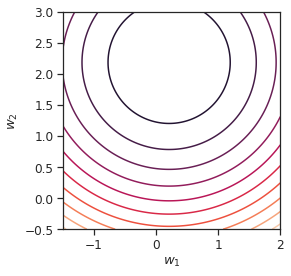

In [10]:
def plot_objective_contours(X, y, xlim=[-1.5,2], ylim=[-0.5,3]):
    XX,YY = np.meshgrid(np.linspace(*xlim,200), np.linspace(*ylim,200))
    W = np.hstack([np.ravel(XX)[:,None], np.ravel(YY)[:,None]])
    ZZ = [J(w, X, y) for w in W]
    ZZ = np.array(ZZ).reshape(XX.shape)

    cn = plt.contour(XX,YY,ZZ,levels=10)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel("$w_1$")
    plt.ylabel("$w_2$")
    
plot_objective_contours(X, y)

### Implementing gradient descent

Now that we have the hypothesis and the cost function we can implement the gradient descent routine. First, write a function $\nabla J(w)$ which returns the gradient of the cost function. The gradient is just a vector with all the partial derivatives
$$
\nabla J(w) = \bigg[\frac{\partial J(w)}{\partial w_1} , \dotsc, \frac{\partial J(w)}{\partial w_d} \bigg]^T
$$
The gradient of the least squares objective is
$$
\nabla J(w) = \frac{2}{m}X^{\intercal}(Xw-y)
$$
when written in matrix-form (compare this to the script).

In [11]:
# implement the following function.
def dJ(w, X, y): 
    """
    gradient of objective function
    :param w: weights/paramters
    :param X: data matrix with x_i^T in the ith row
    :param y: vector of labels
    :return gradient of J with respect to w
    """
    dJ = np.zeros(len(w))
    m = X.shape[0]
    for j in range(len(w)):
      res = 0
      for i in range(m):
        res = res + 2/m * X[i][j] * (np.dot(w,X[i]) - y[i])
      dJ[j] = res
    
    return dJ

In [12]:
# test the correctness of dJ
w = np.ones(d)
assert dJ(w,X,y).shape == (2,) # we expect a vector of size (2,)
np.testing.assert_almost_equal(scipy.optimize.check_grad(J, dJ, w, X, y), 0.0, decimal=3) # test the gradient

Next, you will implement gradient descent in the function.
Recall the update rule of gradient descent which is
$$
w^{t+1} = w^{t} - \alpha \nabla J(w^{t})
$$

In order to inspect the performance of the algorithm it is necessary to store the weights $w^{t}$ at each iteration $t = 1,\dots,iters$.

In [13]:
def gradientDescent(dJ, X, y, w0, alpha, iters):
    """
    function that performs gradient descent
    :param w: weights/paramters
    :param X: data matrix with x_i^T in the ith row
    :param y: vector of labels
    :return the optimal weights and a list of all weights calculated
    """
    w = w0                           # initial weights
    ws = np.zeros([iters, len(w0)])  # memory to remember weights
    for t in range(iters):           # for t = 1, ..., iters
        w = w - alpha * dJ(w,X,y)# <--- put your code here
        ws[t,:] = w
    return w, ws

We can now use gradient descent to find the optimal parameters, $w$, that will minimzed the sum squared error between observed and predicted values.

In [14]:
w0 = np.zeros(d) # initial weights
alpha = 0.05  # learning rate
iters = 100    # number of iterations

w, ws = gradientDescent(dJ, X, y, w0, alpha, iters)
print(f"optimal weights w: {w}")

# testing the correctness of gradientDescent
np.testing.assert_array_almost_equal(w,[0.20979352, 2.18552917], decimal=1) # test optimal weights

optimal weights w: [0.20949966 2.18552917]


### Verifying Gradient Descent

A good way to verify that gradient descent is working correctly is to look at the values $J(w)$ and check that it is decreasing with each step.
Compare the following plot ti Fig. 1.5 in the script.

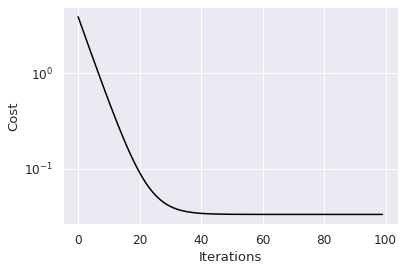

In [15]:
def plot_progress(costs, log=True):
    with sns.axes_style("darkgrid"):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(costs)), costs, 'k')
        ax.set_xlabel('Iterations')
        ax.set_ylabel('Cost')
        if log:
            ax.set_yscale('log')
        return ax
    
plot_progress([J(w,X,y) for w in ws]);

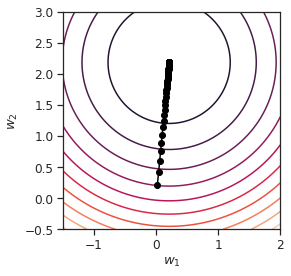

In [16]:
plot_objective_contours(X, y)
plt.plot(ws[:,0], ws[:,1], '-ko');

We use the final paramers to plot the linear fit.
Compare this to Fig. 1.7 in the script.

[-3.31428871  1.        ] [0.20949966 2.18552917]


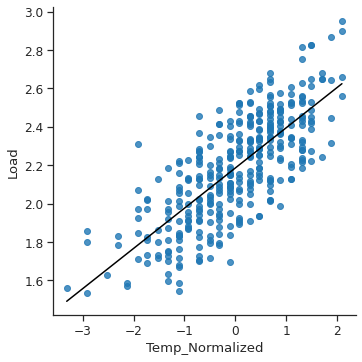

In [17]:
def plot_fit(h, w, normalized=True):
    outputs = 'Load'
    inputs = 'Temp_Normalized' if normalized else 'Temp'
    hue='Label' if 'Label' in df.columns else None
    
    t = np.linspace(df[inputs].min(), df[inputs].max(), 100)
    x = np.vstack([t, np.ones(t.shape)]).T
    y = np.squeeze(h(w,x))

    sns.lmplot(x=inputs, y=outputs, hue=hue, data=df, fit_reg=False)
    plt.plot(t, y, 'k', label='Prediction')
    
plot_fit(h, w)    

Estimate the peak deman for tomorrow if the temperature is 83 degree Fahrenheit.

### Omitting Feature Scaling

Plot the objective and gradient descent progress without feature scaling. Compare this to Fig. 1.8 in the script.

In [18]:
X = df[['Temp','Bias',]].values 
y = df['Load'].values

# Try different values for alpha and iters.
# With the following defaults, you will get numerical errors.
w, ws = gradientDescent(dJ, X, y, w0, alpha=0.001, iters=100) 
print(f"calculated weights: {w}")
print(f"optimal weights:    [ 0.04198241 -1.19732703]")



calculated weights: [-3.08387199e+106 -3.81250535e+104]
optimal weights:    [ 0.04198241 -1.19732703]


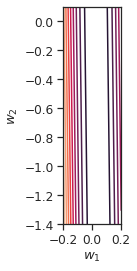

In [19]:
# plot objective contours
plot_objective_contours(X, y, xlim=[-.2,.2], ylim=[-1.4,.1])



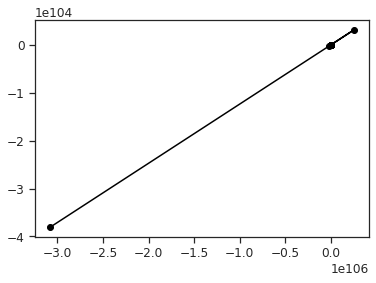

In [20]:
# plot only 100 weights
idx = np.linspace(0, len(ws)-1, 100).astype(int)
plt.plot(ws[idx,0], ws[idx,1], '-ko')



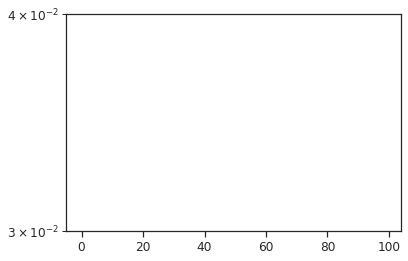

In [21]:
# plot the objective values for the weights on a log scale
fig, ax = plt.subplots()
ax.plot(idx, [J(w,X,y) for w in ws[idx,:]])
ax.axis(ymin=0.03, ymax=0.04)
ax.set_yscale('log')

## Ananalytic Solution to Least Squares

We now that there exits a closed-form solution to linear regression which is
$$
w = \big(X^TX \big)^{-1}X^Ty
$$
Using this formula does not require any feature scaling, and you will get
an exact solution in one calculation: there is no "loop until convergence" like
in gradient descent. However, it can only used with the squared loss.

Important: In general, one should avoid calculating inverses as this leads to numerical problems. Instead, use `np.linalg.solve` to solve the system of linear equations $X^TXw=X^Ty$.

In [22]:
#w = np.zeros((2,)) # <-- replace this with the close-form solution
a = np.dot(X.transpose() , X)
b = np.dot(X.transpose() , y)
w = np.linalg.solve(a,b)


[64.04  1.  ] [ 0.04198241 -1.19732703]


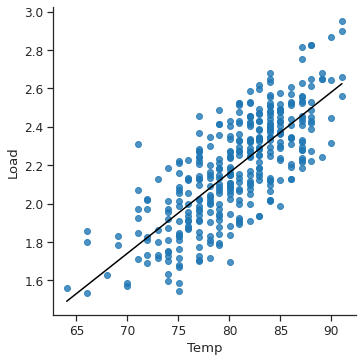

In [23]:
plot_fit(h, w, normalized=False) 

## Additional Features

Create a column `df["IsWeekday"]`, which is `1` if the date corresponds to a weekday and `0` otherwise.
Use the `datetime` library to determine the day of week.

In [24]:
# add the weekday column to our data frame
#print (df["IsWeekday"])
#

print (df)
#df["IsWeekday"] = True # Your code here

             Temp     Load  IsWeekday  Bias  Temp_Normalized
Date                                                        
2013-06-01  84.92  2.29866      False     1         0.869820
2013-06-02  80.06  2.02608      False     1        -0.104067
2013-06-03  69.08  1.83254       True     1        -2.304331
2013-06-04  71.96  1.82701       True     1        -1.727213
2013-06-05  80.06  2.10931       True     1        -0.104067
...           ...      ...        ...   ...              ...
2013-06-02  78.08  1.71487      False     1        -0.500836
2013-06-08  75.02  1.83368      False     1        -1.114025
2013-06-09  75.02  1.84533      False     1        -1.114025
2013-06-15  77.00  1.91130      False     1        -0.717256
2016-07-04  75.92  1.91317       True     1        -0.933675

[357 rows x 5 columns]


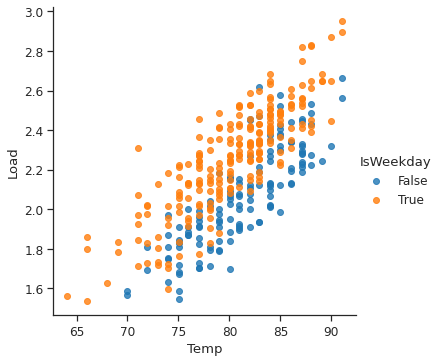

In [25]:
sns.lmplot(x='Temp', y='Load', hue='IsWeekday', data=df, fit_reg=False)

Calculate the optimal weights for the model with the additional `IsWeekday` feature using the closed-form solution.

In [26]:
# Code to find closed form solution with an additional feature
X = df[['Temp_Normalized','IsWeekday','Bias',]].values 
y = df['Load'].values
(n,d) = X.shape
w0 = np.ones(d) # initial weights

#a = np.dot(X.transpose() , X)
a=np.matrix(np.dot(X.transpose() , X), dtype='float')
#b = np.dot(X.transpose() , y)
b =np.matrix(np.dot(X.transpose() , y), dtype='float')

w = np.linalg.solve(a,b.transpose())
w = np.reshape(w,(1,3))
print(w)
#w, ws = gradientDescent(dJ, X, y, w0, alpha=0.001, iters=100) 


# optimal weights w: [ 0.04411637  0.23488175 -1.51402559] for unnormalised data
# optimal weights w: [[0.22015438 0.23488175 2.04084217]] for normalised data

[[0.22015438 0.23488175 2.04084217]]


Visualize the model fit by plotting the resulting predictions for both the weekend and weekday cases.

[-3.31428871  1.          1.        ] [[0.22015438 0.23488175 2.04084217]]
[-3.31428871  0.          1.        ] [[0.22015438 0.23488175 2.04084217]]


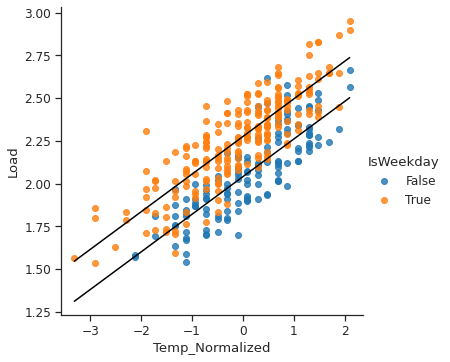

In [27]:
# insert your code here.

def plot_fit_new(h, w, normalized=True):
    outputs = 'Load'
    inputs = 'Temp_Normalized' if normalized else 'Temp'
    #hue='Label' if 'Label' in df.columns else None
    hue='IsWeekday'
    
    t = np.linspace(df[inputs].min(), df[inputs].max(), 357)
    is_weekday = df['IsWeekday'].values
    true_is_weekday = [x for x in is_weekday if x == True]
    false_is_weekday = [x for x in is_weekday if x == False]

    sns.lmplot(x=inputs, y=outputs, hue=hue, data=df, fit_reg=False)
    # Here no need to consider the data points, we should draw lines and so we substitute ones and zeros as follows for IsWeekday input feature
    x = np.vstack([t, np.ones(t.shape),np.ones(t.shape)]).T # ones -> corresponding to the IsWeekday = True  
    y = np.squeeze(h(w,x))
    plt.plot(t, y, 'k', label='Prediction')

    x = np.vstack([t, np.zeros(t.shape),np.ones(t.shape)]).T # zeros -> corresponding to the IsWeekday = False 
    y = np.squeeze(h(w,x))
    plt.plot(t, y, 'k', label='Prediction_2')
    
plot_fit_new(h, w, normalized=True) 